# Problem
Extracting the essential information from lengthy texts is a crucial task in many domains.  Text summarization techniques, powered by advanced NLP models, address this challenge by automatically generating concise and informative summaries.

# Solution using Bart 
Recent years have witnessed significant strides in  NLP, particularly with the advent of powerful deep learning models. Among these, BART (Bidirectional and Auto-Regressive Transformers) has emerged as a leading architecture for abstractive text summarization. BART's strength lies in its ability to generate concise and fluent summaries that capture the essence of the input text, going beyond simply extracting key phrases.

In this notebook, we delve into the practical application of the BART base model for news summarization. Using the CNN/Daily Mail tiny dataset, we will fine-tune BART and assess its ability to extract key information and generate coherent summaries from news articles.

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
!pip install evaluate rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:0000:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=123d6c417d9ab4830d2adb90201959a620314fab52e1080e9a61349829a5a07e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


# Installing Libraries

In [3]:
from sklearn.model_selection import train_test_split
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
)
import torch
import matplotlib.pyplot as plt

In [4]:
torch.cuda.empty_cache()

# Data Loading and Preprocessing

In [5]:
dataset = load_dataset("llamafactory/cnn_dailymail_tiny")

README.md:   0%|          | 0.00/557 [00:00<?, ?B/s]

train.json:   0%|          | 0.00/8.00M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 1000
    })
})

In [7]:
dataset['train'][0]

{'instruction': 'You are an expert journalist, please write a summary based on the content.',
 'input': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film 

In [8]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [9]:
input_lengths = []
output_lengths = []

for example in dataset['train']:
    input_lengths.append(len(example['input'].split()))
    output_lengths.append(len(example['output'].split()))

input_length_range = (min(input_lengths), max(input_lengths))
output_length_range = (min(output_lengths), max(output_lengths))

average_input_length = sum(input_lengths) / len(input_lengths)
average_output_length = sum(output_lengths) / len(output_lengths)

print(f"Input Length Range: {input_length_range}")
print(f"Output Length Range: {output_length_range}")
print(f"Average Input Length: {average_input_length:.2f} words")
print(f"Average Output Length: {average_output_length:.2f} words")

Input Length Range: (18, 1831)
Output Length Range: (11, 69)
Average Input Length: 601.81 words
Average Output Length: 43.15 words


In [10]:
def tokenize_function(examples):
    inputs = tokenizer([' '.join(thread) for thread in examples['input']], max_length=1024, truncation=True)
    outputs = tokenizer(examples['output'], max_length=128, truncation=True)
    inputs['labels'] = outputs['input_ids']
    return inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [12]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [13]:
metric = evaluate.load("rouge")

# Model Fine-tuning

In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=10,
    fp16=True,
    evaluation_strategy="steps",
    eval_steps=10,
    save_steps=1e6,
    save_total_limit=2,
    load_best_model_at_end=True,
    push_to_hub=False, 
    report_to="none",
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [16]:
train_results = trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss,Validation Loss
10,5.528300,3.977499
20,4.600700,3.902179
30,4.492800,3.881373
40,4.363600,3.845096
50,4.349100,3.839240
60,4.264900,3.822318
70,4.267700,3.824893
80,4.256000,3.817781
90,4.173900,3.811908


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


# Saving Model

In [23]:
trainer.save_model("my_summarization_model")
tokenizer.save_pretrained("my_summarization_tokenizer")

('my_summarization_tokenizer/tokenizer_config.json',
 'my_summarization_tokenizer/special_tokens_map.json',
 'my_summarization_tokenizer/vocab.json',
 'my_summarization_tokenizer/merges.txt',
 'my_summarization_tokenizer/added_tokens.json',
 'my_summarization_tokenizer/tokenizer.json')

# Evaluation

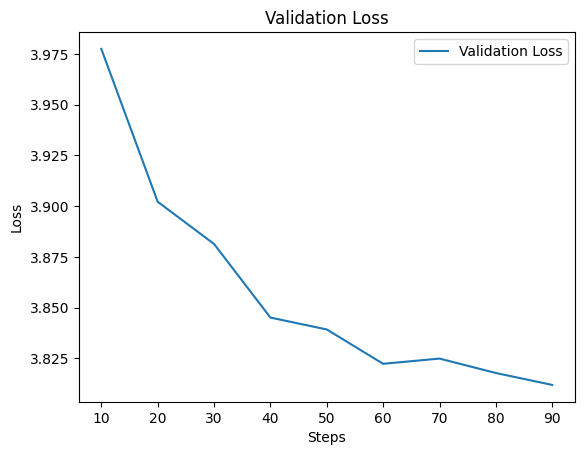

In [17]:
train_loss_history = trainer.state.log_history

eval_steps = []
eval_losses = []
for log_entry in train_loss_history:
    if "eval_loss" in log_entry:
        eval_steps.append(log_entry['step'])
        eval_losses.append(log_entry['eval_loss'])

train_steps = [entry['step'] for entry in train_loss_history[::10]]
train_losses = [entry['loss'] for entry in train_loss_history[::10]]

plt.plot(eval_steps, eval_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [18]:
sample = "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct."

In [19]:
model.eval()

def generate_summary(text, max_length=92, num_beams=4):
    inputs = tokenizer(text, return_tensors='pt', max_length=1024, truncation=True)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}
    with torch.no_grad():
        summary_ids = model.generate(inputs['input_ids'], 
                                      attention_mask=inputs['attention_mask'], 
                                      max_length=max_length, 
                                      num_beams=num_beams,
                                      early_stopping=True)
    
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

text = """Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation. Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders. The Welsh Government said more people than ever were getting help to address housing problems. Changes to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation. Prison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered. However, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority. Andrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need for accommodation was "chronic". "There's a desperate need for it, finding suitable accommodation for those leaving prison there is just a lack of it everywhere," he said. "It could take six months to a year, without a lot of help they could be on the streets for six months. "When you think of the consequences of either being on the street, especially with the cold weather at the moment or you may have a roof over your head, sometimes there is only one choice." Mr Stevens believes building more one-bedroom flats could help ease the problem. "The average price is a hundred pounds a week to keep someone in a rented flat, prison is a lot more than that so I would imagine it would save the public purse quite a few pounds," he said. Official figures show 830 one-bedroom properties were built in the year to March 2016, of an overall total of 6,900 new properties in Wales. Marc, 50, who has been in and out of prison for the past 20 years for burglary offences, said he struggled to find accommodation each time he was released. He said he would ask himself: "Where am I going to stay? Where am I going to live? Have I got somewhere where I can see my daughter." "You're put out among the same sort of people doing the same sort of thing, and it's difficult, it's difficult to get away from it. It's like every man for himself, there's nothing." Marc has now found stable accommodation with homeless charity Emmaus and said it had been life changing. "You feel safe, you got hot food, you've got company of people in similar situations to yourself but all dealing with different issues. It's a constructive, helpful atmosphere," he said. Tom Clarke, chief executive of Emmaus South Wales, agreed there was not enough support available. "We do still see [people] homeless on the streets, so clearly they haven't got accommodation and haven't got provision," he said. "I think the key is connecting people with the services they need. I don't delude myself that Emmaus can offer a one size fits all for everyone, we can't. "But there must be other opportunities and given suitable encouragement I believe that can and should happen." A Welsh Government spokesman said the national pathway for homeless services to children, young people and adults in the secure estate had prevented many people from losing their home whilst serving their prison sentence. It added there were already significant demands for one-bedroom flats across the public and private sector and it was providing 20,000 new affordable homes in the next five years."""
summary = generate_summary(sample)
print("Generated Summary:", summary)

Generated Summary: The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City


In [20]:
summary2 = generate_summary(text)
print("Generated Summary:", summary2)

Generated Summary: Prison officials say they are working to improve the quality of life for people who have been released from prison. The charity said it was working to help more people find housing after their release. It said some people were living rough for up to a year before finding suitable accommodation. Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders. The Welsh Government said more people than ever were getting help to address housing problems.


In [24]:
!zip -r my_summarization_model.zip my_summarization_model
!zip -r my_summarization_tokenizer.zip my_summarization_tokenizer

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: my_summarization_model/ (stored 0%)
  adding: my_summarization_model/generation_config.json (deflated 47%)
  adding: my_summarization_model/config.json (deflated 63%)
  adding: my_summarization_model/training_args.bin (deflated 51%)
  adding: my_summarization_model/model.safetensors (deflated 7%)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: my_summarization_tokenizer/ (stored 0%)
  adding: my_summarization_tokenizer/merges.txt (deflated 53%)
  adding: my_summarization_tokenizer/tokenizer.json (deflated 82%)
  adding: my_summarization_tokenizer/special_tokens_map.json (deflated 52%)
  adding: my_summarization_tokenizer/vocab.json (deflated 59%)
  adding: my_summarization_tokenizer/tokenizer_config.json (deflated 75%)
